# Visualising FITS and star positions

In [1]:
import requests, math, glob
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
#from astroquery.simbad import Simbad
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/home/jovyan/work')
import init
import reading
import do_calibration

import importlib
importlib.reload(do_calibration)

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2


In [2]:
FITS_FILE=init.fitsdir+init.reference_frame
FITS_FILE_FTS=init.convfitsdir+'kout000001.fts'
wcs_file = init.basedir+"new-image.fits"
PADDING = 200

In [3]:
def getWcs(wcs_file):
    hdulist = fits.open(wcs_file)
    data = hdulist[0].data.astype(float)
    header = hdulist[0].header
    wcs = WCS(header)
    return wcs

wcs = getWcs(wcs_file)

vsx_catalog, vsx_dict = do_calibration.create_vsx_astropy_catalog()
candidates = do_calibration.getCandidates(0.5)
detections_catalog = do_calibration.create_detections_astropy_catalog(do_calibration.get_detected_stars())



#x_pix, y_pix = wcs.all_world2pix(ra_deg, dec_deg)
# x_world, y_world = gc.pixel2world(np.array([700]), np.array([700]))

Creating astropy Catalog with 528255 objects...


AttributeError: module 'do_calibration' has no attribute 'get_detected_stars'

In [23]:
do_calibration.get_detected_stars()

AttributeError: module 'do_calibration' has no attribute 'get_detected_stars'

In [13]:
idx, d2d, d3d = match_coordinates_sky(vsx_catalog, detections_catalog)

In [14]:
print(len(idx))
result_f = []
for index, entry in enumerate(d2d):
    if entry.value < 0.01:    
        #print(entry.value)
        result_f.append({'auid': vsx_dict['metadata'][index]['Name'], 'coord': SkyCoord(vsx_dict['ra_deg_np'][index], vsx_dict['dec_deg_np'][index], unit='deg')})
print(len(result_f))
#print(len(set(result_f)))
#result_f.sort()
#result_f = list(map(lambda f: f+1, result_f))
##print(result_f)
#matches = detections_catalog[idx]
#print(matches[0])

528255
18


In [15]:
#vsx_to_star = do_calibration.find_star_for_known_vsx(vsx, detections)
#result=[]
#for key in vsx_to_star:
#    result.append(vsx_to_star[key][1])
#print(result)

In [16]:
# auid	dec	error	peak	ra	vmag	x	y

results = []
found_results = []

#for variable in vsx:
#    results.append({'auid': variable[0], 'coord': variable[1]})
results = result_f

#for key in detections:
#    found_results.append({'auid': str(key), 'coord': SkyCoord(detections[key][0], detections[key][1], unit='deg')})

for candidate in candidates:
    if candidate[0] < 1000:
        found_results.append({'auid': str(candidate[0]), 'coord': candidate[4]})


def add_pixels(results, offset):
    for star in results:
        star_coord = star['coord']
        xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=0)
        x = xy[0].item(0)
        y = xy[1].item(0)
        star['x'] = x + offset
        star['y'] = y + offset
    results = pd.DataFrame(results)
    return results
results = add_pixels(results, PADDING)
found_results = add_pixels(found_results, PADDING)
print("nr of found result:", len(found_results))
#print(found_results)

nr of found result: 273


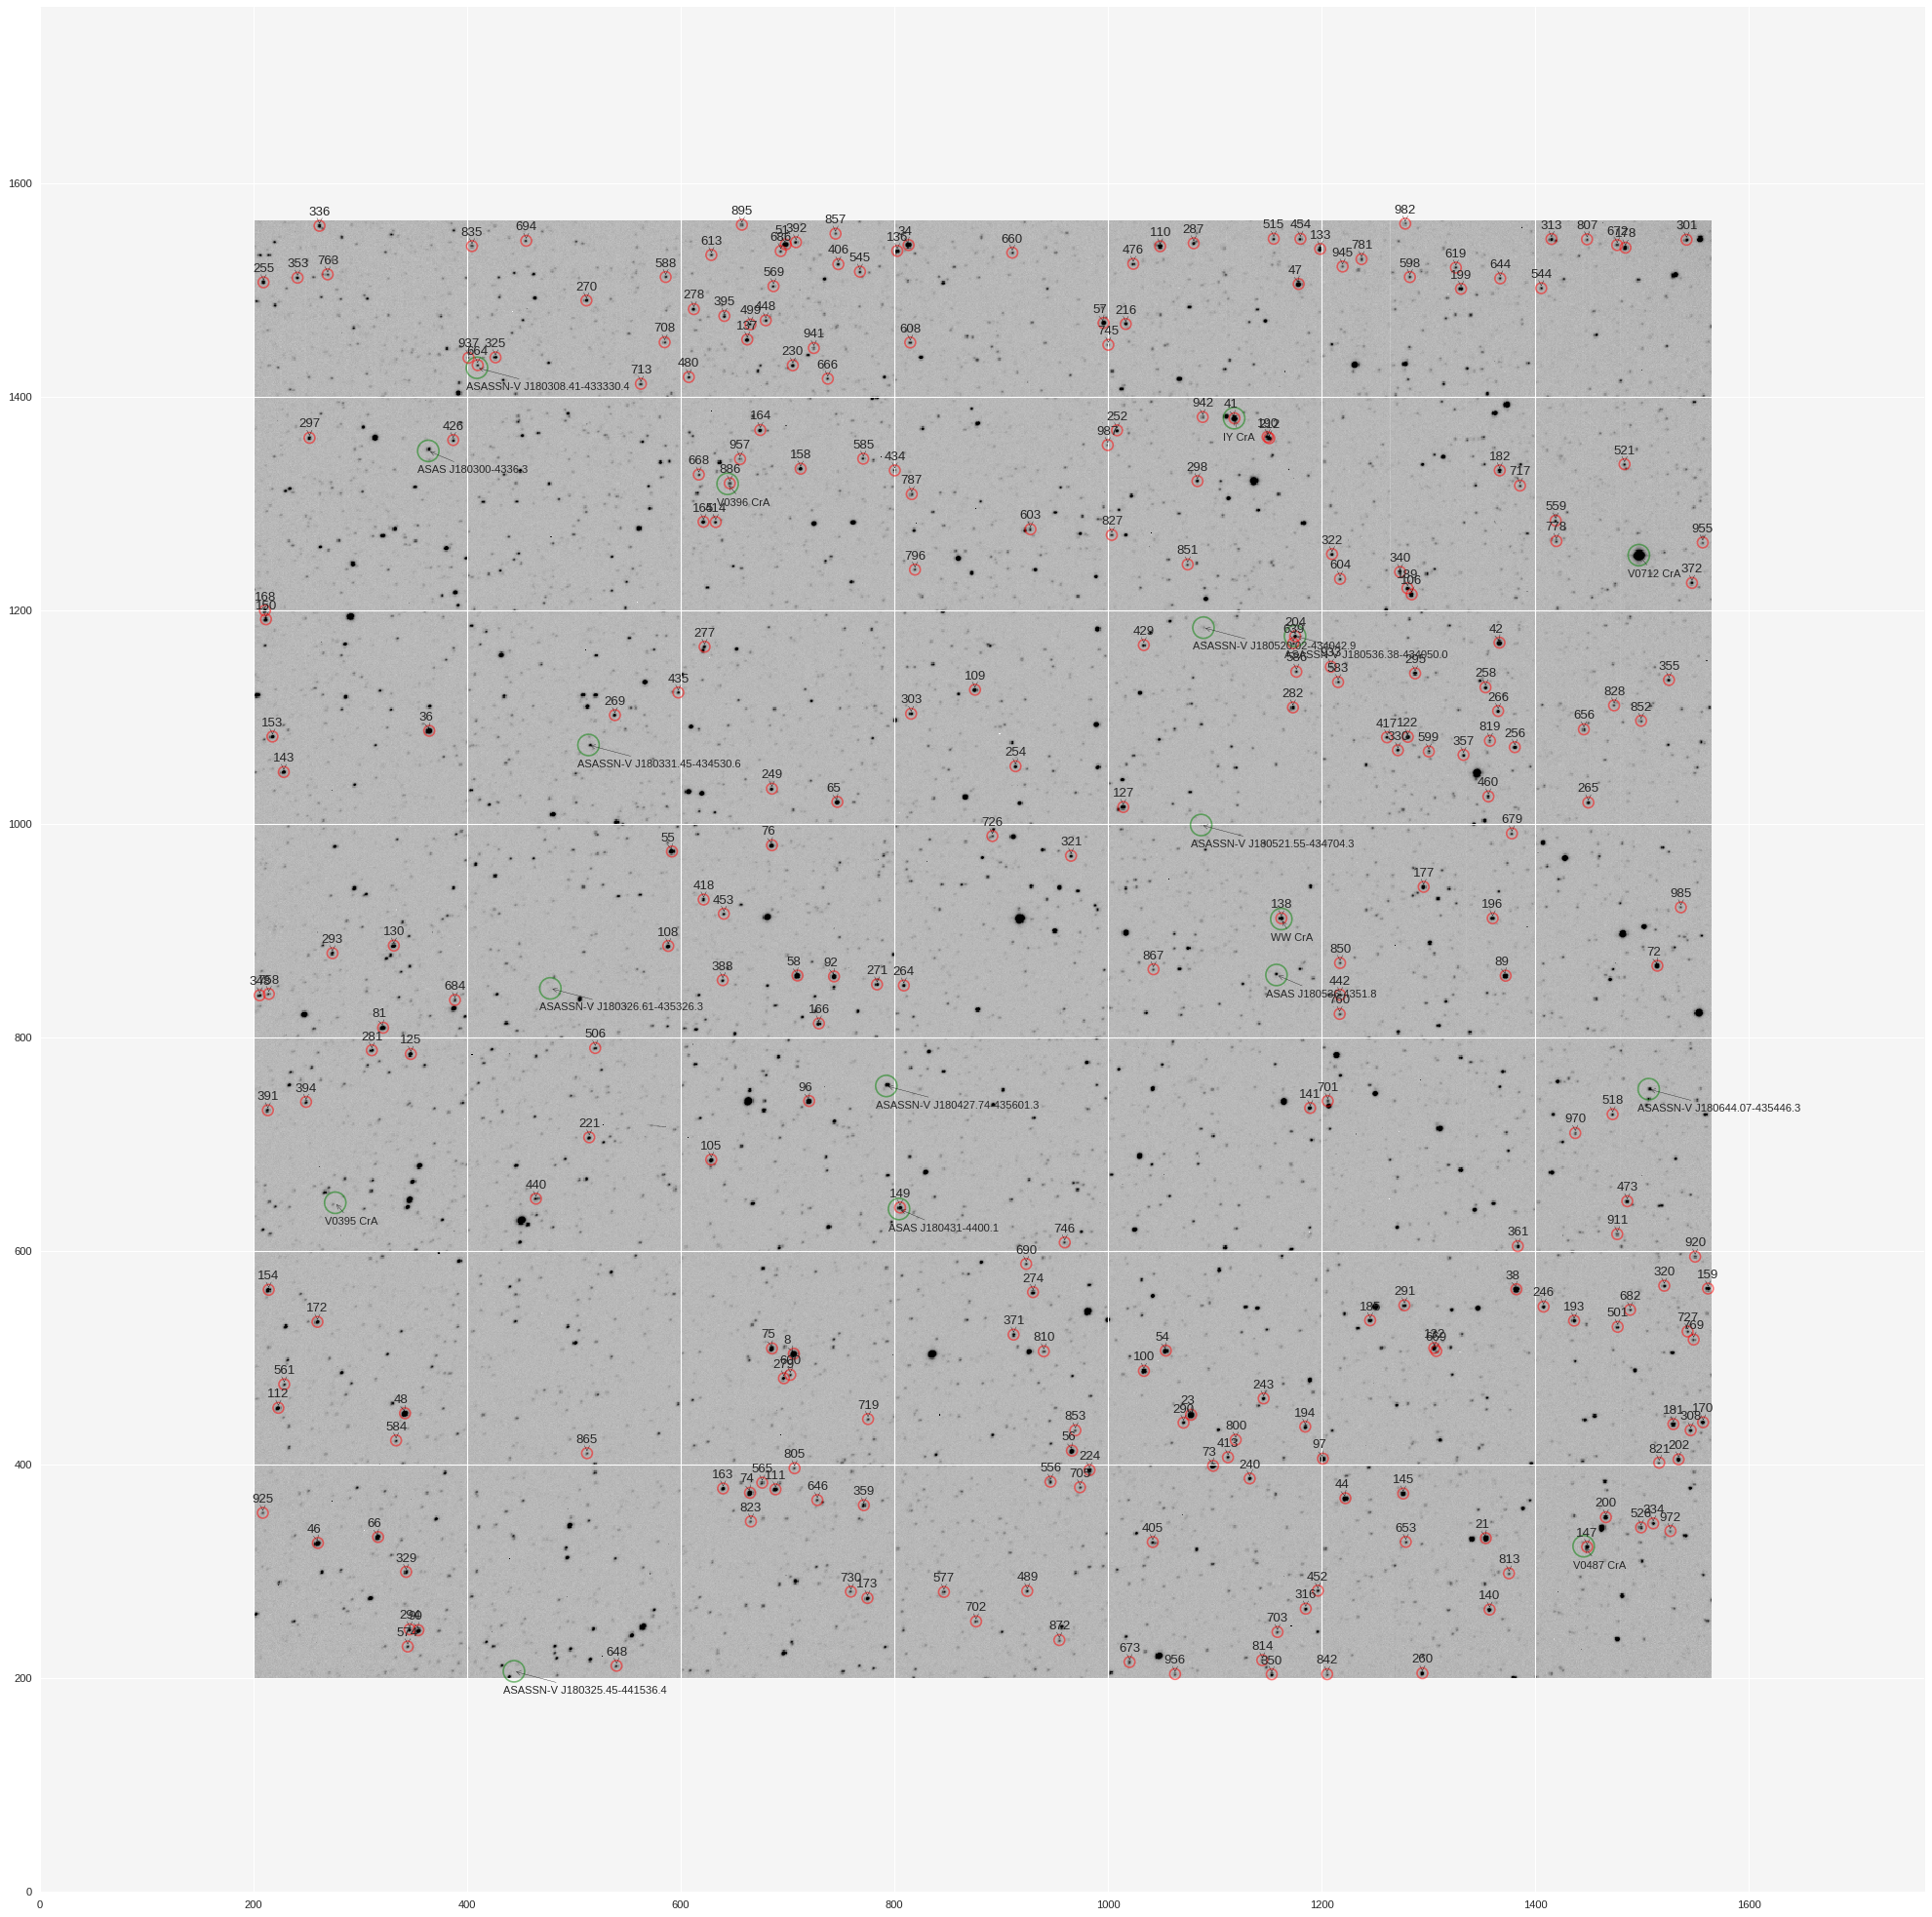

In [17]:
hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)
data = np.pad(data, (PADDING,PADDING), 'constant', constant_values=(100, 100))
fig=plt.figure(figsize=(36, 32), dpi= 80, facecolor='w', edgecolor='k')
known_positions = (results['x'], results['y'])    
found_positions = (found_results['x'], found_results['y'])
known_apps = CircularAperture(known_positions, r=10.)    
found_apps = CircularAperture(found_positions, r=5.)    
# target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
known_apps.plot(color='green', lw=1.5, alpha=0.5)
found_apps.plot(color='red', lw=1.5, alpha=0.5)
# target_app.plot(color='blue', lw=1.5, alpha=0.5)
#to_plot = results
def annotate_it(results, offset1, offset2, size=16):
    for to_annotate in results.iterrows():
        #star_name = to_annotate[1]['auid'] if to_annotate[1]['auid'] != 
        plt.annotate('{}'.format(to_annotate[1]['auid']),
            xy=(to_annotate[1]['x'], to_annotate[1]['y']), xycoords='data',
            xytext=(offset1, offset2), textcoords='offset points', size=(size if to_annotate[1]['auid'] != '227' else size+10),
            arrowprops=dict(arrowstyle="->"))
annotate_it(results, -10, -20, size=10)    
annotate_it(found_results, -10, 10, size=12)    


In [18]:
fig.savefig(init.basedir+'found_vars_10k_upsilon_more_1k')
plt.close(fig)

## Draw all 1000 stars

In [9]:
len(candidates)

83

In [10]:
#print(hdulist[0]._header)
#print(hdulist2[0]._header)
diff(hdulist, hdulist2)

NameError: name 'diff' is not defined